# Modeling and Model Evaluation


1. Read cleaned data and define feature matrix `X` and target `y`
2. Baseline accuracy 
3. Train and evaluate simple benchmark model
4. Define pipelines to test in `GridsearchCV`

    4a. Vectorization to test: `CountVectorizer` and `TfidfVectorizer` with parameter grid
    
    4b. Models to test: `LogisticRegression`, `SVC`, 
    

5. Run `GridSearchCV` on all pipelines and calculate metrics
6. Define best models and save using pickle
7. Compute metrics

In [219]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## 1. Read data and define feature matrix and target vector

In [220]:
df = pd.read_csv("../data/data_cleaned_askastrologers_askastronomy.csv")

## 2. Baseline accuracy

In [221]:
df['subreddit'].value_counts(normalize=True)

askastrologers    0.549352
askastronomy      0.450648
Name: subreddit, dtype: float64

__Baseline accuracy__: 0.54

### Convert `subreddit` column to `int` (`askastrologers`=1, `askastronomy`=0)

In [222]:
df['subreddit']=df['subreddit'].map({'askastrologers':1,'askastronomy':0})

In [223]:
df.dtypes

name           object
created_utc    object
post           object
subreddit       int64
dtype: object

## Define feature/target dataframes 

In [329]:
X = df['post']
y = df['subreddit']

In [357]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# y = df['subreddit']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [358]:
pipe_cvec_logr = Pipeline([
    ('cvec',CountVectorizer(stop_words='english',ngram_range=(1,1),token_pattern=r"\b[a-zA-Z]+\b")),
    ('logr',LogisticRegression())
])

In [359]:
pipe_cvec_logr_params = {
    'cvec__max_features':[1000,2500,5000],
    # 'cvec__ngram_range':[(1,1)],
    'cvec__min_df':[0.01,0.02,0.05],
    'cvec__max_df':[0.95,0.99],
    'logr__C':[0.01,0.1,1.0,5.0],
    'logr__solver':['liblinear'],
    'logr__penalty':['l1','l2']
}

In [362]:
gs_logreg = GridSearchCV(pipe_cvec_logr, pipe_cvec_logr_params,cv=5,n_jobs=-1,verbose=1)

In [363]:
gs_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words='english',
                                                        token_pattern='\\b[a-zA-Z]+\\b')),
                                       ('logr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.95, 0.99],
                         'cvec__max_features': [1000, 2500, 5000],
                         'cvec__min_df': [0.01, 0.02, 0.05],
                         'logr__C': [0.01, 0.1, 1.0],
                         'logr__penalty': ['l1', 'l2'],
                         'logr__solver': ['liblinear']},
             verbose=1)

In [368]:
gs_logreg.best_score_

0.9581285694278023

In [369]:
logreg_best = gs_logreg.best_estimator_

In [370]:
logreg_best.score(X_test, y_test), logreg_best.score(X_train,y_train)

(0.9620535714285714, 0.9927414852037968)

In [371]:
logreg_best

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.95, max_features=1000, min_df=0.01,
                                 stop_words='english',
                                 token_pattern='\\b[a-zA-Z]+\\b')),
                ('logr', LogisticRegression(solver='liblinear'))])

### Evaluation:

`LogisticRegression` with `CountVectorizer` is overfit 99.9% train accuracy and 96% test accuracy. Try reducing `max_features` and `TfidfVectorizer`

Save model as pickle file:

In [372]:
import pickle as pkl 
with open('models/logreg_cvec.pkl', 'wb') as f:
    pkl.dump(logreg_best,f)


In [373]:
with open('models/logreg_cvec.pkl','rb') as f:
    logreg_best = pkl.load(f)

In [374]:
print(logreg_best.steps)

[('cvec', CountVectorizer(max_df=0.95, max_features=1000, min_df=0.01,
                stop_words='english', token_pattern='\\b[a-zA-Z]+\\b')), ('logr', LogisticRegression(solver='liblinear'))]


### 3. Metrics Define function to compute metrics and format as a metrics `DataFrame`


In [375]:
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, recall_score, precision_score, roc_auc_score #cross_val_score
def metrics_df(est, X_val, y_val, X_ts=None, y_ts=None):

    train_test_both=True if ((X_ts is not None) and (y_ts is not None)) else False


    X_lst = [X_val, X_ts] if train_test_both else [X_val]
    y_lst = [y_val, y_ts] if train_test_both else [y_val]
    metrics_dict=[]
    for X_set,y_set in zip(X_lst,y_lst):
        
        tn, fp, fn, tp = confusion_matrix(y_set, est.predict(X_set)).ravel()
        y_pred = est.predict_proba(X_set)
        # y_pred = np.transpose([pred[] for pred in y_pred])
        metrics_dict.append({

        'accuracy': est.score(X_set,y_set),
        'balanced accuracy':balanced_accuracy_score(y_set, est.predict(X_set)),

        'sensitivity':tp/(tp+fn),
        'specificity':tn/(tn+fp),
        'F1':f1_score(y_set,est.predict(X_set),pos_label=est.classes_[0]),
        'ROC AUC':roc_auc_score(y_set,y_pred[:,-1],average=None)
                            
            } )

    return pd.DataFrame(metrics_dict,index=[['train','test'][i] for i in range(len(X_lst))])


In [376]:
metrics_df(logreg_best,X_train,y_train,X_test,y_test)

,accuracy,balanced accuracy,sensitivity,specificity,F1,ROC AUC
train,0.992741,0.992837,0.991870,0.993804,0.991960,0.999820
test,0.962054,0.962791,0.955285,0.970297,0.958435,0.991115


In [377]:
print(metrics_df(logreg_best,X_train,y_train,X_test,y_test).to_markdown())

|       |   accuracy |   balanced accuracy |   sensitivity |   specificity |       F1 |   ROC AUC |
|:------|-----------:|--------------------:|--------------:|--------------:|---------:|----------:|
| train |   0.992741 |            0.992837 |      0.99187  |      0.993804 | 0.99196  |  0.99982  |
| test  |   0.962054 |            0.962791 |      0.955285 |      0.970297 | 0.958435 |  0.991115 |


<Figure size 640x480 with 0 Axes>

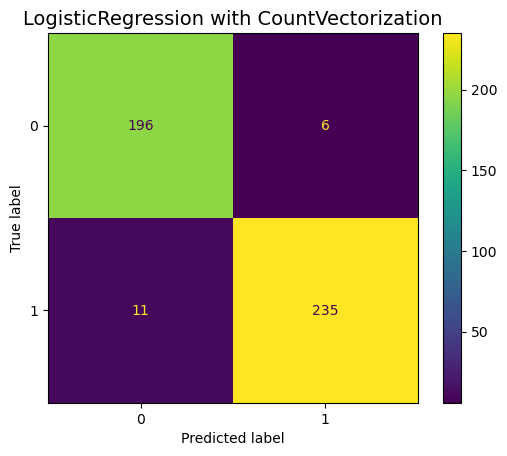

In [378]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure()
ConfusionMatrixDisplay(confusion_matrix(y_test,logreg_best.predict(X_test))).plot()
plt.title("LogisticRegression with CountVectorization",fontsize=14)
plt.savefig("../images/logreg_cvec_best_confusion_mat.png",dpi=150,bbox_inches='tight')
plt.show()

### SVM model

In [379]:
from sklearn.svm import SVC,LinearSVC

pipe_cvec_svm  = Pipeline([
    ('cvec',CountVectorizer(stop_words='english',ngram_range=(1,1),token_pattern=r"\b[a-zA-Z]+\b")),
    ('svc',SVC(probability=True))
])

In [380]:
pipe_cvec_svm_params = {
    'cvec__max_features':[1000,2500,5000],
    'cvec__ngram_range':[(1,1)],
    'cvec__min_df':[0.01,0.02,0.05],
    'cvec__max_df':[0.95,99],
    'svc__C':[0.01,0.1,1.0],
    'svc__kernel':['rbf','linear','poly']
}


In [383]:
gs_svm = GridSearchCV(pipe_cvec_svm, pipe_cvec_svm_params,cv=5, n_jobs=-1, verbose=1)

In [384]:
gs_svm.fit(X_train,y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words='english',
                                                        token_pattern='\\b[a-zA-Z]+\\b')),
                                       ('svc', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.95, 99],
                         'cvec__max_features': [1000, 2500, 5000],
                         'cvec__min_df': [0.01, 0.02, 0.05],
                         'cvec__ngram_range': [(1, 1)],
                         'svc__C': [0.01, 0.1, 1.0],
                         'svc__kernel': ['rbf', 'linear', 'poly']},
             verbose=1)

In [385]:
gs_svm.best_estimator_, gs_svm.best_score_

(Pipeline(steps=[('cvec',
                  CountVectorizer(max_df=0.95, max_features=1000, min_df=0.01,
                                  stop_words='english',
                                  token_pattern='\\b[a-zA-Z]+\\b')),
                 ('svc', SVC(C=0.1, kernel='linear', probability=True))]),
 0.9531006364669083)

In [386]:
svm_best = gs_svm.best_estimator_

In [387]:
import pickle as pkl 
with open('models/svm_cvec_best.pkl', 'wb') as f:
    pkl.dump(svm_best,f)


In [393]:
import pickle as pkl 
with open('models/svm_cvec_best.pkl','rb') as f:
    svm_best = pkl.load(f) 


In [395]:
svm_best

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.95, max_features=1000, min_df=0.01,
                                 stop_words='english',
                                 token_pattern='\\b[a-zA-Z]+\\b')),
                ('svc', SVC(C=0.1, kernel='linear', probability=True))])

In [396]:
svm_best.get_params(deep=False)

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(max_df=0.95, max_features=1000, min_df=0.01,
                   stop_words='english', token_pattern='\\b[a-zA-Z]+\\b')),
  ('svc', SVC(C=0.1, kernel='linear', probability=True))],
 'verbose': False}

In [400]:
metrics_df(svm_best,X_train,y_train,X_test,y_test)

,accuracy,balanced accuracy,sensitivity,specificity,F1,ROC AUC
train,0.982133,0.981177,0.990854,0.971499,0.980000,0.999271
test,0.957589,0.956069,0.971545,0.940594,0.952381,0.991115


In [401]:
print(metrics_df(svm_best,X_train,y_train,X_test,y_test).to_markdown())

|       |   accuracy |   balanced accuracy |   sensitivity |   specificity |       F1 |   ROC AUC |
|:------|-----------:|--------------------:|--------------:|--------------:|---------:|----------:|
| train |   0.982133 |            0.981177 |      0.990854 |      0.971499 | 0.98     |  0.999271 |
| test  |   0.957589 |            0.956069 |      0.971545 |      0.940594 | 0.952381 |  0.991115 |


/var/folders/t0/z45sbs_x4qggjl5km6v2t42m0000gn/T/ipykernel_30139/1989062011.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("../images/svm_cvec_best_confusion_mat.png",dpi=150,bbox_tight=True)


<Figure size 640x480 with 0 Axes>

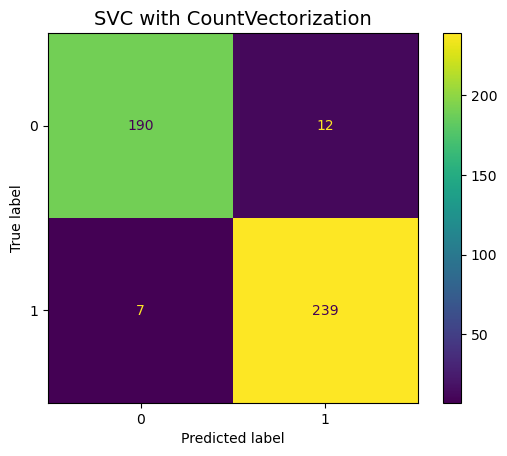

In [399]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure()
ConfusionMatrixDisplay(confusion_matrix(y_test,svm_best.predict(X_test))).plot()
plt.title("SVC with CountVectorization",fontsize=14)

plt.savefig("../images/svm_cvec_best_confusion_mat.png",dpi=150,bbox_tight=True)
plt.show()

## Conclusions:

- The __SVC__ model performs best, with 0.997 train and 0.954 test balanced accuracy